In [1]:
import matplotlib.pyplot as plt
from time import time
from simfunctions import *
import matplotlib as mpl

colors = mpl.colormaps['Dark2'].colors

# Homodimerization

$$ \emptyset \xrightarrow{k_1} mX_1 $$
$$ X_1 + X_1 \xrightarrow{k_2} X_2 $$
$$ X_1 \xrightarrow{k_3} \emptyset, \quad X_2 \xrightarrow{k_3} \emptyset$$

with parameter $k_1 = 1000, k_2 = 100, k_3 = 10$.

In [2]:
def rate1(X):
    return 1

def rate2(X):
    rate = X[0]*(X[0]-1)  # 0.5(X^2 - X) 
    if rate > 0:
        return rate
    else:
        return 0

def rate3(X):
    rate = X[0]
    if rate > 0:
        return rate
    else:
        return 0
    
def rate4(X):
    rate = X[1]
    if rate > 0:
        return rate
    else:
        return 0
    
def jac(X):
    return np.array([[0,0], [2.5*(2*X[0]-1),0], [0.5, 0], [0, 0.5]])
    
# Model Parameters
drift = [rate1, rate2, rate3, rate4]
S_matrix = np.array([[1, 0], [-2, 1], [-1, 0], [0, -1]])  # Stoichiometry matrix
c = np.array([5, 2.5, 0.5, 0.5])  # Reaction rates
X0 = np.array([20, 0])  # Initial state
T = 1  # Total time


## SSA

In [3]:
n_runs = 5000
runs = []

start = time()
for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_ssa = next_reaction(drift, S_matrix, c, X0, T)
    runs.append(X)
end = time()

print('Computed in: ', np.round(end-start,3))
x_ssa = np.mean(np.array(runs), axis=0)


0.0 % simulations completed


C:\Users\birik\github\SOGA4SSA\src\simfunctions.py:25: RuntimeWarning: divide by zero encountered in divide
  rand_vars = np.random.exponential(1 / a)


10.0 % simulations completed
20.0 % simulations completed
30.0 % simulations completed
40.0 % simulations completed
50.0 % simulations completed
60.0 % simulations completed
70.0 % simulations completed
80.0 % simulations completed
90.0 % simulations completed
Computed in:  15.044


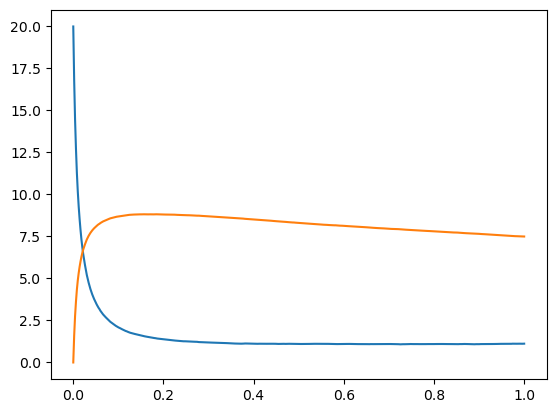

In [4]:
plt.plot(t_ssa, x_ssa)

## Tau-leaping

In [14]:
tau = 0.005 # Leap size

n_runs = 1000
runs = []

start = time()
for run in range(n_runs):
    if 100*run/n_runs % 10 == 0:
        print(100*run/n_runs, '% simulations completed')
    X = None
    while X is None:
        X, t_tau = tau_leaping(drift, S_matrix, c, X0, T, tau)
    runs.append(X)
end = time()

print('Computed in: ', np.round(end-start, 3))
    
print('Number of steps: ', len(X))

0.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
10.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
20.0 % simulations completed
Negative population, restarting run
Negative population, restarting run
Negative population, restarting run
30.0 % simulations completed
Negative population, restarting run
Negative population, 

In [15]:
std_tau = np.std(runs, axis=0)

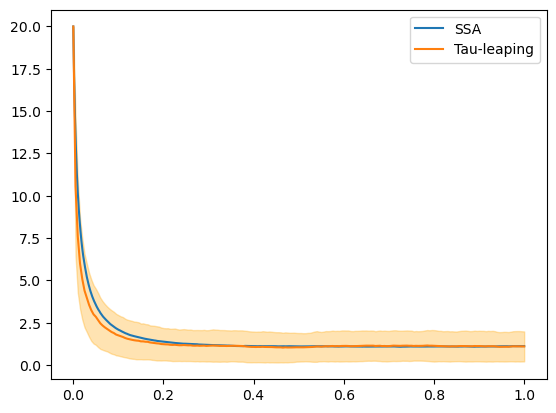

In [16]:
x_tau = np.mean(runs, axis=0)

plt.plot(t_ssa, x_ssa[:,0], label='SSA')
plt.plot(t_tau, x_tau[:,0], label='Tau-leaping')
plt.fill_between(t_tau, x_tau[:,0]-std_tau[:,0], x_tau[:,0]+std_tau[:,0] ,alpha=0.3, color='orange')
plt.legend()

## Mean-field

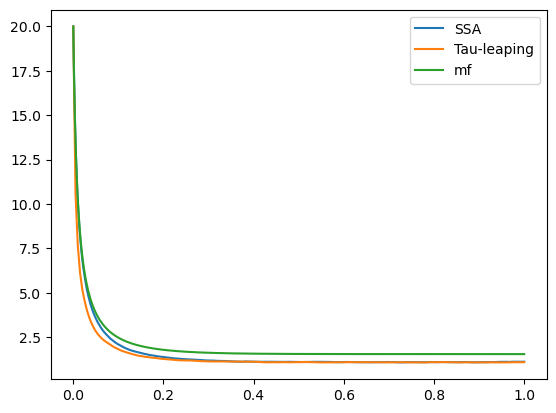

In [8]:

tmf = np.linspace(0,T, 5000)
Xmf = mean_field(drift,S_matrix,c,X0,tmf)

plt.plot(t_ssa, x_ssa[:,0], label='SSA')
plt.plot(t_tau, x_tau[:,0], label='Tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mf')
plt.legend()


## SOGA 

In [17]:
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

compiledFile=compile2SOGA('../programs/SOGA/SSA/HomodimerizationX0=20.soga')
cfg = produce_cfg(compiledFile)
start = time()
output_dist = start_SOGA(cfg)
end = time()

print('Computed in {}s'.format(np.round(end-start,3)))

Computed in 49.663s


In [10]:
t = len(t_tau)

x1 = np.zeros(t)
x2 = np.zeros(t)
std1 = np.zeros(t)
std2 = np.zeros(t)

for i in range(t):
    idx1 = output_dist.var_list.index('X0[{}]'.format(i))
    idx2 = output_dist.var_list.index('X1[{}]'.format(i))
    x1[i] = output_dist.gm.mean()[idx1]
    std1[i] = np.sqrt(output_dist.gm.cov()[idx1,idx1])
    x2[i] = output_dist.gm.mean()[idx2]
    std2[i] = np.sqrt(output_dist.gm.cov()[idx2,idx2])

(-1.0, 5.0)

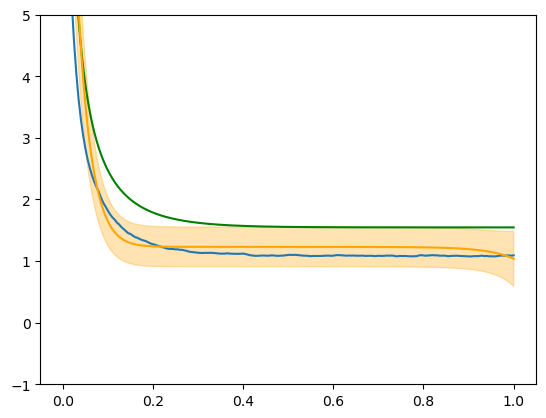

In [11]:
plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.ylim(-1,5)

In [12]:
tcl = np.linspace(0,T, 10)
#Xcl = []
#for i in range(500):
#   Xcl.append(euler_maruyama(drift,S_matrix,c,X0,tmf))

#Xcl_mean = np.mean(np.array(Xcl), axis=0)
#std_xcl = np.std(np.array(Xcl), axis=0)

runs_CLE = []
n_runs_CLE = 1000

start = time()
for run in range(n_runs_CLE):
    X_CLE = None
    while X_CLE is None:
        X_CLE = euler_maruyama(drift,S_matrix,c,X0,tmf)
    runs_CLE.append(X_CLE)
end = time()

print('Computed in: ', np.round(end-start, 3))
    
print('Number of steps: ', len(X_CLE))

Xcl_mean = np.mean(np.array(runs_CLE), axis=0)
std_xcl = np.std(np.array(runs_CLE), axis=0)


Computed in:  281.893
Number of steps:  5000


In [13]:
start = time()
X, Sigma = linear_noise(drift,jac,S_matrix,c,X0,tmf)
end = time()

print('Computed in: ', np.round(end-start, 3))

Computed in:  0.761


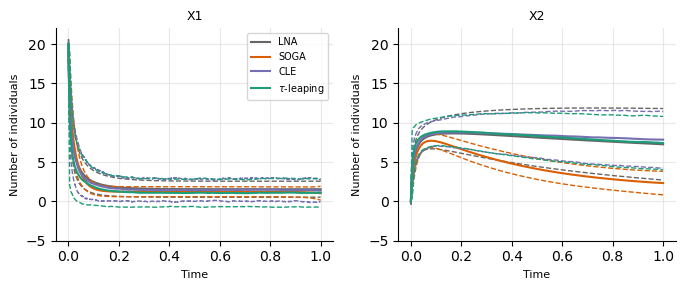

In [20]:
# Plot

fig, axs = plt.subplots(1,2, figsize=(7,3))

axs[0].plot(tmf, X[:,0], label='LNA', color=colors[7])
#axs[0].fill_between(tmf, X[:,0]-np.sqrt(Sigma[:,0,0]), X[:,0]+np.sqrt(Sigma[:,0,0]) ,alpha=0.3,color=colors[7])
axs[0].plot(tmf, X[:,0]-np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)
axs[0].plot(tmf, X[:,0]+np.sqrt(Sigma[:,0,0])*1.96 ,'--',color=colors[7], linewidth=1)

axs[0].plot(t_tau, x1, label='SOGA', color=colors[1])
#axs[0].fill_between(t_tau, xs-stds, xs+stds ,alpha=0.3, color=colors[1])
axs[0].plot(t_tau, x1-std1*1.96 ,'--',color=colors[1], linewidth=1)
axs[0].plot(t_tau, x1+std1*1.96 ,'--',color=colors[1], linewidth=1)

axs[0].plot(tmf, Xcl_mean[:,0], label='CLE', color=colors[2])
#axs[0].fill_between(tmf, Xcl_mean[:,0]-std_xcl[:,0], Xcl_mean[:,0]+std_xcl[:,0] ,alpha=0.3,color=colors[2])
axs[0].plot(tmf, Xcl_mean[:,0]-std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)
axs[0].plot(tmf, Xcl_mean[:,0]+std_xcl[:,0]*1.96 ,'--',color=colors[2], linewidth=1)

axs[0].plot(t_tau, x_tau[:,0], label=r'$\tau$-leaping', color=colors[0])
#axs[0].fill_between(t_tau, Xs-stdS, Xs+stdS ,alpha=0.3, color=colors[0])
axs[0].plot(t_tau, x_tau[:,0]-std_tau[:,0]*1.96 ,'--',color=colors[0], linewidth=1)
axs[0].plot(t_tau, x_tau[:,0]+std_tau[:,0]*1.96 ,'--',color=colors[0], linewidth=1)

axs[0].set_title('X1', fontsize=9)
axs[0].legend(fontsize = 7)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].grid(color='lightgray', alpha=0.5, zorder=1)
axs[0].set_xlabel('Time', fontsize=8)
axs[0].set_ylabel('Number of individuals', fontsize=8)
axs[0].set_ylim(-5,22)

axs[1].plot(tmf, X[:,1], label='LNA', color=colors[7])
#axs[1].fill_between(tmf, X[:,1]-np.sqrt(Sigma[:,1,1]), X[:,1]+np.sqrt(Sigma[:,1,1]) ,alpha=0.3,color=colors[7])
axs[1].plot(tmf, X[:,1]-np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)
axs[1].plot(tmf, X[:,1]+np.sqrt(Sigma[:,1,1])*1.96 ,'--',color=colors[7], linewidth=1)

axs[1].plot(t_tau, x2, label='SOGA', color=colors[1])
#axs[1].fill_between(t_tau, xi-stdi, xi+stdi ,alpha=0.3, color=colors[1])
axs[1].plot(t_tau, x2-std2*1.96 ,'--',color=colors[1], linewidth=1)
axs[1].plot(t_tau, x2+std2*1.96 ,'--',color=colors[1], linewidth=1)

axs[1].plot(tmf, Xcl_mean[:,1], label='CLE', color=colors[2])
#axs[1].fill_between(tmf, Xcl_mean[:,1]-std_xcl[:,1], Xcl_mean[:,1]+std_xcl[:,1] ,alpha=0.3, color=colors[2])
axs[1].plot(tmf, Xcl_mean[:,1]-std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)
axs[1].plot(tmf, Xcl_mean[:,1]+std_xcl[:,1]*1.96 ,'--',color=colors[2], linewidth=1)

axs[1].plot(t_tau, x_tau[:,1], label=r'$\tau$-leaping', color = colors[0])
#axs[1].fill_between(t_tau, Xi-stdI, Xi+stdI, alpha=0.3, color=colors[0])
axs[1].plot(t_tau, x_tau[:,1]-std_tau[:,1]*1.96 ,'--',color=colors[0], linewidth=1)
axs[1].plot(t_tau, x_tau[:,1]+std_tau[:,1]*1.96 ,'--',color=colors[0], linewidth=1)

axs[1].set_title('X2', fontsize=9)
#axs[1].legend(fontsize = 7)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].grid(color='lightgray', alpha=0.5, zorder=1)
axs[1].set_xlabel('Time', fontsize=8)
axs[1].set_ylabel('Number of individuals', fontsize=8)
axs[1].set_ylim(-5,22)

plt.tight_layout()
plt.savefig('homodim_4.png', dpi=300)

## Without observe

(-5.0, 25.0)

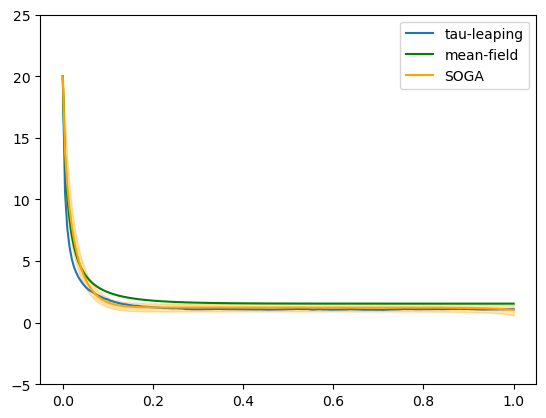

In [15]:
# correction term

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,25)


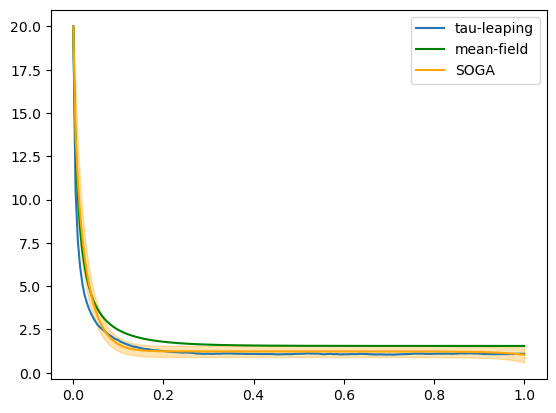

In [16]:
# half variance

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()

(-5.0, 5.0)

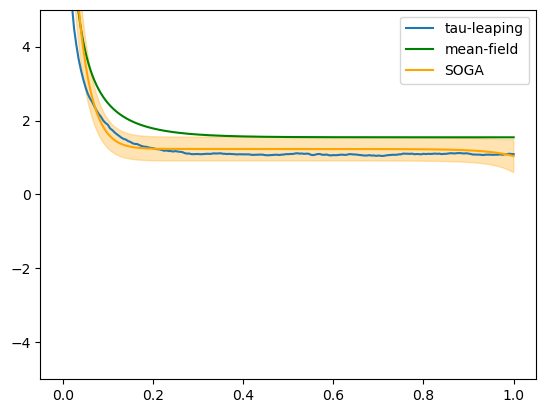

In [17]:
# correcting poisson(N)

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)

(-5.0, 5.0)

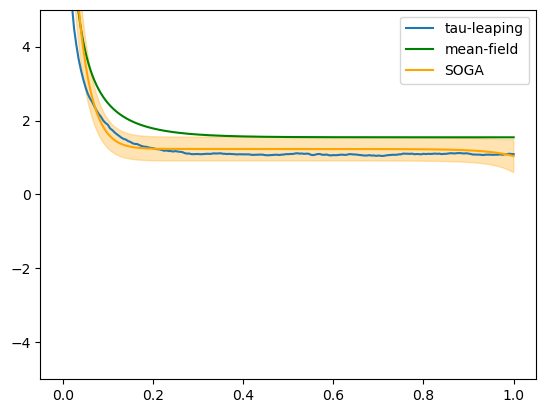

In [18]:
# correcting poisson(delta)

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)

(-5.0, 5.0)

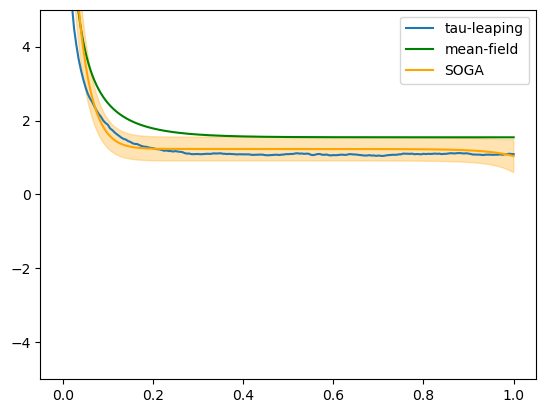

In [19]:
# correcting only k2

plt.plot(t_tau, x_tau[:,0], label='tau-leaping')
plt.plot(tmf, Xmf[:,0], label='mean-field', color='green')
plt.plot(t_tau, x1, label='SOGA', color='orange')
plt.fill_between(t_tau, x1-std1, x1+std1 ,alpha=0.3, color='orange')
plt.legend()
plt.ylim(-5,5)